## EV Adoption Forecasting
As electric vehicle (EV) adoption surges, urban planners need to anticipate infrastructure needs—especially charging stations. Inadequate planning can lead to bottlenecks, impacting user satisfaction and hindering sustainability goals.

**Problem Statement:** Using the electric vehicle dataset (which includes information on EV populations, vehicle types, and possibly historical charging usage), create a model to forecast future EV adoption. For example, predict the number of electric vehicles in upcoming years based on the trends in the data.

**Goal:** Build a regression model that forecasts future EV adoption demand based on historical trends in EV growth, types of vehicles, and regional data.

**Dataset:** This dataset shows the number of vehicles that were registered by Washington State Department of Licensing (DOL) each month. The data is separated by county for passenger vehicles and trucks.

- Date: Counts of registered vehicles are taken on this day (the end of this month). - 2017-01-31
2024-02-29
- County: This is the geographic region of a state that a vehicle's owner is listed to reside within. Vehicles registered in Washington
- State: This is the geographic region of the country associated with the record. These addresses may be located in other
- Vehicle Primary Use: This describes the primary intended use of the vehicle.(Passenger-83%, Truck-17%)
- Battery Electric Vehicles (BEVs): The count of vehicles that are known to be propelled solely by an energy derived from an onboard electric battery.
- Plug-In Hybrid Electric Vehicles (PHEVs): The count of vehicles that are known to be propelled from energy partially sourced from an onboard electric battery
- Electric Vehicle (EV) Total: The sum of Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs).
- Non-Electric Vehicle Total: The count of vehicles that are not electric vehicles.
- Total Vehicles: All powered vehicles registered in the county. This includes electric vehicles.
- Percent Electric Vehicles: Comparison of electric vehicles versus their non-electric counterparts.

**Dataset Link:** https://www.kaggle.com/datasets/sahirmaharajj/electric-vehicle-population-size-2024/data

### Import Required Libraries

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Dataset

In [2]:
# Load data
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv")

### Explore and Understand the Data

In [3]:
df.head() # top 5 rows

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


Total 20819 data points and 10 features.

In [4]:
# no of rows and cols
df.shape

(20819, 10)

In [5]:
# Data Types, class and memory alloc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

As we could see, only Percent Eletric Vehicles is numeric.

In [6]:
df.isnull().sum()

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

Missing values in County and State.

### 🔍 Comprehensive Data Quality Assessment

Let's perform a thorough data quality check to understand our dataset better.

In [17]:
# 1. Data Quality Summary
print("=== DATA QUALITY ASSESSMENT ===")
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. Missing Data Analysis
missing_summary = df.isnull().sum()
missing_percentage = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Count', ascending=False)

print("\n=== MISSING DATA ANALYSIS ===")
print(missing_df[missing_df.Missing_Count > 0])

# 3. Data Types and Unique Values
print("\n=== COLUMN ANALYSIS ===")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {df[col].dtype} | Unique values: {unique_count}")

# 4. Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"\n=== DUPLICATES ===")
print(f"Duplicate rows: {duplicate_count}")

# 5. Basic statistics for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    print(f"\n=== NUMERIC COLUMN STATISTICS ===")
    print(df[numeric_cols].describe())

=== DATA QUALITY ASSESSMENT ===
Dataset Shape: (20819, 10)
Memory Usage: 7.83 MB

=== MISSING DATA ANALYSIS ===
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

=== COLUMN ANALYSIS ===
Date: datetime64[ns] | Unique values: 86
County: object | Unique values: 312
State: object | Unique values: 51
Vehicle Primary Use: object | Unique values: 2
Battery Electric Vehicles (BEVs): object | Unique values: 1209
Plug-In Hybrid Electric Vehicles (PHEVs): object | Unique values: 935
Electric Vehicle (EV) Total: int64 | Unique values: 1409
Non-Electric Vehicle Total: object | Unique values: 7096
Total Vehicles: object | Unique values: 7095
Percent Electric Vehicles: float64 | Unique values: 498

=== DUPLICATES ===
Duplicate rows: 0

=== NUMERIC COLUMN STATISTICS ===
       Electric Vehicle (EV) Total  Percent Electric Vehicles
count                 20819.000000               20819.000000
mean                    297.579855                   2.122378
std                    2915

**Check if any column contain outliers.**

In [18]:
# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 0


### Data Preprocessing

Basic Data Cleaning

In [19]:
# Converts the "Date" column to actual datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Removes rows where "Date" conversion failed
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


Remove Outliers: Cap the values to the IQR bounds

In [20]:
# Cap the outliers - it keeps all the data while reducing the skew from extreme values.

df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


### 📊 Data Visualization & Insights

Visualizations help us understand patterns and trends in the data.

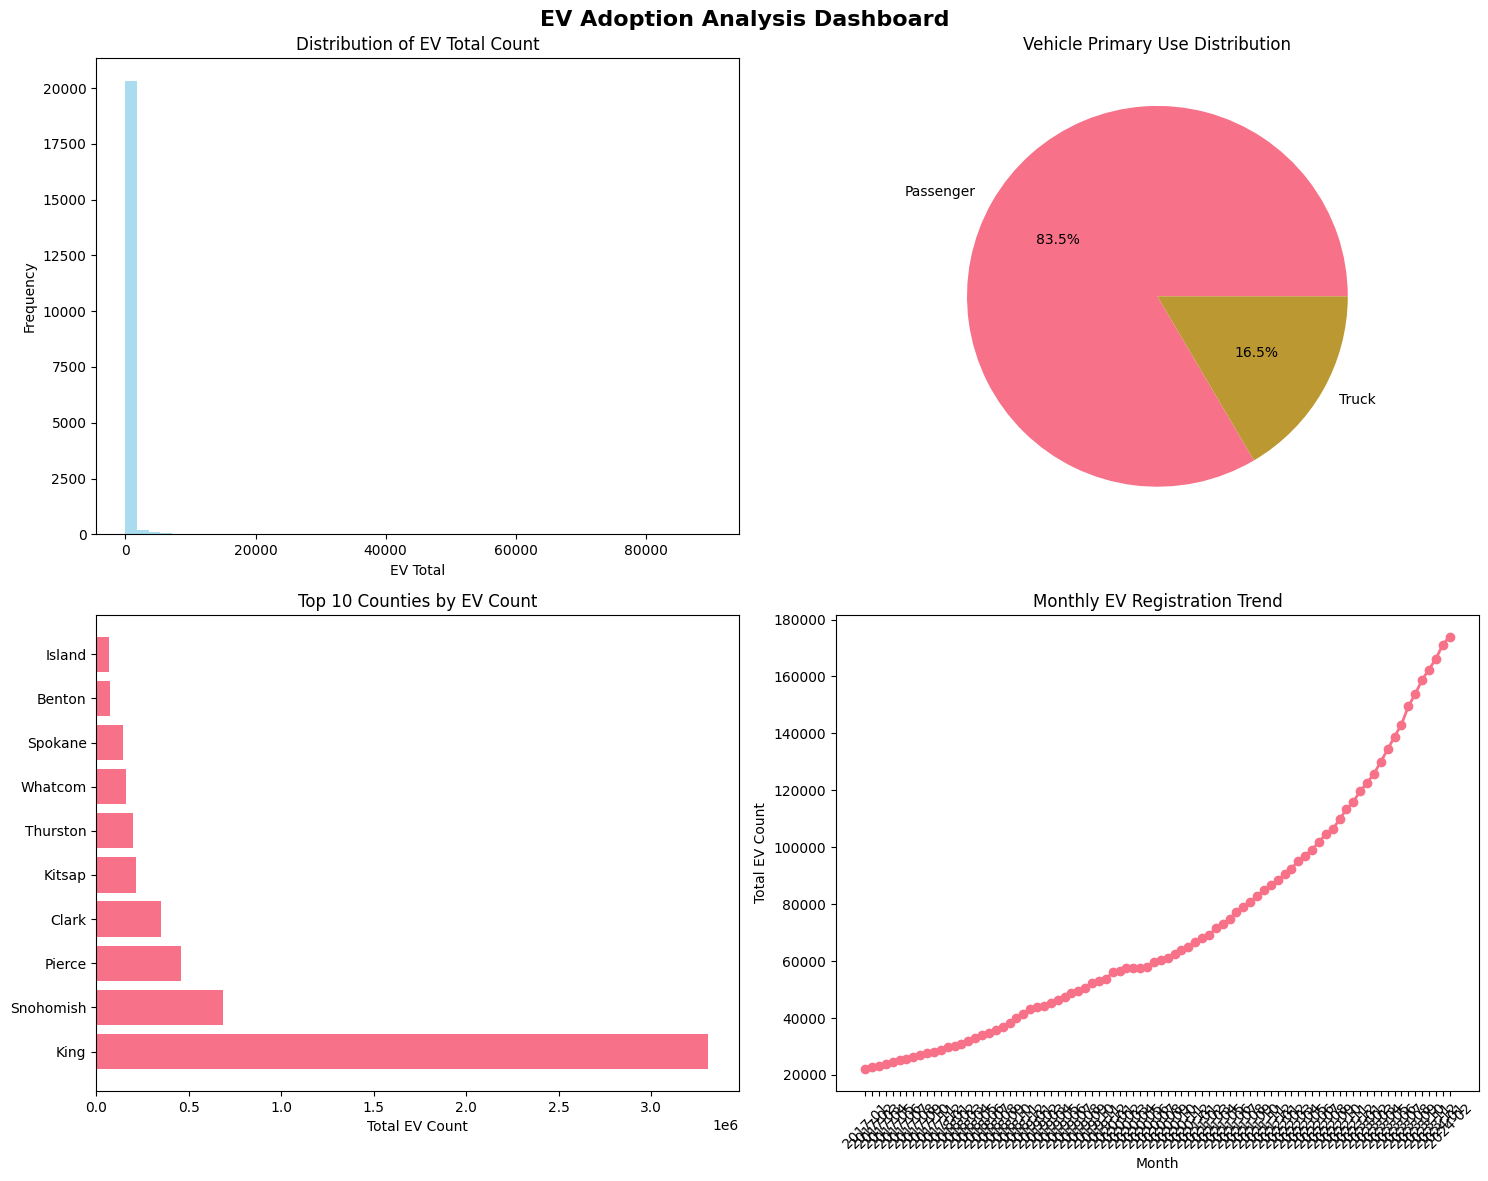

🔍 KEY INSIGHTS:
• Total EV registrations: 6,195,315
• Average EVs per county per month: 297.6
• Peak month: 2024-02
• Top county: King (3,309,850 EVs)


In [21]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('EV Adoption Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. EV Total distribution
axes[0, 0].hist(df['Electric Vehicle (EV) Total'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of EV Total Count')
axes[0, 0].set_xlabel('EV Total')
axes[0, 0].set_ylabel('Frequency')

# 2. Vehicle Primary Use distribution
vehicle_type_counts = df['Vehicle Primary Use'].value_counts()
axes[0, 1].pie(vehicle_type_counts.values, labels=vehicle_type_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Vehicle Primary Use Distribution')

# 3. Top 10 Counties by EV Count
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(10)
axes[1, 0].barh(top_counties.index, top_counties.values)
axes[1, 0].set_title('Top 10 Counties by EV Count')
axes[1, 0].set_xlabel('Total EV Count')

# 4. Monthly EV trend over time
monthly_ev = df.groupby(df['Date'].dt.to_period('M'))['Electric Vehicle (EV) Total'].sum()
axes[1, 1].plot(monthly_ev.index.astype(str), monthly_ev.values, marker='o', linewidth=2)
axes[1, 1].set_title('Monthly EV Registration Trend')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Total EV Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print some key insights
print("🔍 KEY INSIGHTS:")
print(f"• Total EV registrations: {df['Electric Vehicle (EV) Total'].sum():,}")
print(f"• Average EVs per county per month: {df['Electric Vehicle (EV) Total'].mean():.1f}")
print(f"• Peak month: {monthly_ev.idxmax()}")
print(f"• Top county: {top_counties.index[0]} ({top_counties.values[0]:,} EVs)")